# Validation cluster

* __Objectif__:  pour plusieurs méthodes de clustering, comparer la variance intra-classes, et le nombre optimal de clusters selon plusieurs heuristiques.
* __Rappel papier NCAA__ [Olteanu et al.] §3: "and then to classify individual IRIS blocks __into four groups__ for sets 1 and 2 and six groups for the third set." https://arxiv.org/abs/1705.03213
* __Data__: SOM1
* __Algorithmes:__ kmeans, pam (Partitioning Around Medoids), hierarchical clustering (hclust), SOM+hclust, ACP+hclust.
* __Heuristiques:__ "gap statistic", BIC, silhouette.

Lien direct [Conclusion](#Conclusion)

##  Variance intra-classes: comparaison

Dans un premier temps on va comparer la __variance intra-classe__ obtenue pour plusieurs algorithmes de clustering, quand K varie.

In [3]:
library(factoextra)
library(readxl)
library(cluster)
library(SOMbrero) 
library(FactoMineR)
fname = "data/cluster_validation.RData"
load( fname)
options(repr.plot.width=5, repr.plot.height=4);


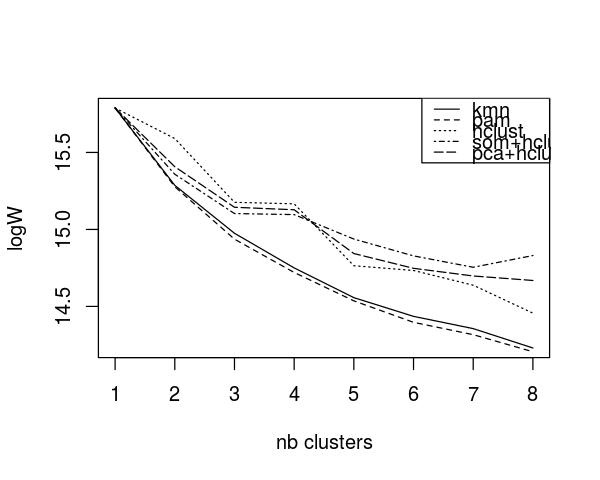

In [2]:
# within-cluster variance across algorithms

algo_names<-c('kmn', 'pam', 'hclust','som+hclust','pca+hclust')	
varname= "logW"#"E.logW"
xrange=c(1,8)
yrange=range(gs.som$Tab[, varname],range(gs.kmn$Tab[, varname]))
plot(xrange, yrange, type="n", xlab="nb clusters",
   ylab=varname ) 
lines(gs.kmn$Tab[, varname], lty=1)
lines(gs.pam$Tab[, varname], lty=2)
lines(gs.hclus$Tab[, varname], lty=3)
lines(gs.som$Tab[, varname], lty=4)
lines(gs.pcahclus$Tab[, varname], lty=5)
legend("topright",algo_names,lty=c(1,2,3,4,5))


Figure ci-dessus:

* les méthodes qui donnent la variance intra-classe la plus basse pour toutes les valeurs de K sont __kmeans et pam__. 
* SOM+HClust trouve une variance intra-classe inférieure à PCA+HClust et Hclust pour un nombre de cluster compris entre 1 et 4. 

## Heuristique 1 pour trouver le nombre de clusters optimal : gap statistic

Dans un second temps on va comparer le résultat de quelques heuristiques existantes permettant de trouver __le nombre optimal de clusters__, noté $k_{opt}$.

In [14]:
fviz_gap_stat(gs.kmn,maxSE = list(method ="firstSEmax", SE.factor = 1))

Figure ci-dessus: statistique de gap de Hastie et al, l'heuristique "firstSEmax" trouve __1 cluster__.

Puis on compare de manière systématique __toutes les heuristiques__ basées sur la "gap statistic", pour tous les algos:

In [8]:
# compute optimal k 
SE.factor=1
mets <- formals(maxSE)$method
l=list("firstSEmax", "Tibs2001SEmax", "globalSEmax", "firstmax", "globalmax")

K.min = 2 
r=sapply(list(gs.kmn, gs.pam, gs.hclus,gs.som,gs.pcahclus), function(gs)
	lapply(l, function(M){ 	
		K.max=gs$call$K.max		
		gap <- gs$Tab[K.min:K.max, "gap"]
		se <- gs$Tab[K.min:K.max, "SE.sim"]
		#print(list(gap, se, M, SE.factor))
		k <- maxSE(gap, se, method = M, SE.factor = SE.factor)
		return(k)		
		}))         
         
colnames(r)<-algo_names
rownames(r)<-l
print(r)

              kmn pam hclust som+hclust pca+hclust
firstSEmax    1   5   2      2          2         
Tibs2001SEmax 1   1   2      2          2         
globalSEmax   7   7   7      6          4         
firstmax      1   5   2      2          2         
globalmax     7   7   7      6          5         


Commentaire: les heuristiques trouvent __des résultats distincts__: $k_{opt} \in \{1,2,4,5,6,7\}$. Note: on a exclu le cas $k_{opt}=1$.

## Heuristique 2: Méthode bayésienne

Ici on emploie un algorithme bayésien, qui modélise les données comme un mélange de nuages gaussiens. 

In [5]:
library(mclust)
d_clust <- Mclust(as.matrix(data), G=1:20);


Package 'mclust' version 5.4.2
Type 'citation("mclust")' for citing this R package in publications.


model-based optimal number of clusters: 4 


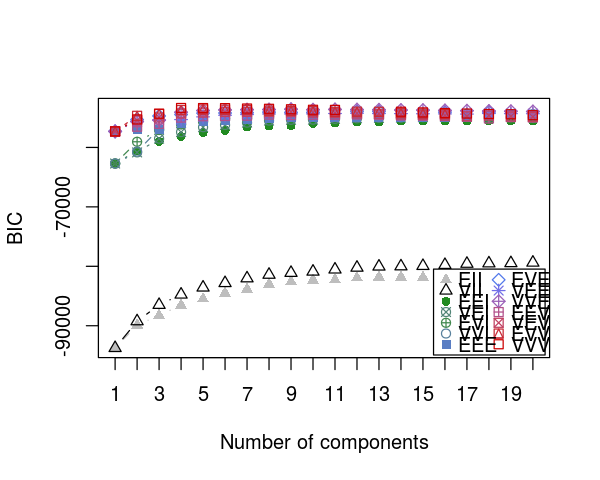

In [6]:
m.best <- dim(d_clust$z)[2]
cat("model-based optimal number of clusters:", m.best, "\n")
# plot
plot(d_clust,what='BIC')
#plot(d_clust,what='classification')

Commentaire: avec cette méthode on trouve __4 clusters__.

# Heuristique 3: silhouette

In [7]:
library(fpc)
pamk.best <- pamk(data)
cat("number of clusters estimated by optimum average silhouette width:", pamk.best$nc, "\n")
#plot(pam(data, pamk.best$nc))


number of clusters estimated by optimum average silhouette width: 2 


## Heuristique 4: $\Delta(Q)/\Delta(Q+1)$

"Let $∆(Q)$ the between-inertia increase when moving from $Q−1$ to $Q$ clusters, the criterion proposed is: $∆(Q)/∆(Q + 1)$. The number $Q$ which minimised this criterion is kept" [Husson, Josse, Pagès 2010]


In [8]:
varname= "logW"
r=sapply(list(gs.kmn, gs.pam, gs.hclus,gs.som,gs.pcahclus), function(gs){
	K.max=gs$call$K.max
	i=which.min(gs.kmn$Tab[1:K.max-1, varname]/gs.kmn$Tab[2:K.max, varname])		
	return(i+1)
	})
r=as.matrix(r)	
rownames(r)<-algo_names
print(r)

           [,1]
kmn           7
pam           7
hclust        7
som+hclust    7
pca+hclust    7


# Conclusion

* Les algorithmes kmeans, pam minimisent la variance intra-classe pour $k \in [1,8]$. L'algorithme SOM arrive en 3eme, meilleur que (pca+hclust, hclust) lorsque $k \in [1,4]$.
* nombre de clusters optimal: on trouve des résultats très variables, dans l'ensemble $\{1,2,4,5,6,7\}$, en fonction de l'heuristique choisie. On peut justifier a posteriori (!) le choix de k=4 en s'appuyant sur le critère BIC.


REFS:

* [Hastie et al.] "The elements of statistical learning" §14.3
* [Husson, Josse, Pagès 2010] "Principal component methods - hierarchical clustering - partitional clustering: why would we need to choose for visualizing data ?"